In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset and preprocess
df = pd.read_csv("data/processed/processed_v1.csv", low_memory=False)
for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna("Missing").astype(str)             # Fill NaNs with the string "Missing" (required for CatBoost)

X = df.drop('Sales Price', axis=1)
y = df['Sales Price']

# Store categorical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"Identified {len(cat_features)} categorical features.")

Identified 37 categorical features.


In [3]:
# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42 
)

print("Data successfully loaded and split.")
print(f"Total shape:    {X.shape}")
print(f"Train shape:    {X_train.shape}")
print(f"Validate shape: {X_val.shape}")
print(f"Test shape:     {X_test.shape}")

Data successfully loaded and split.
Total shape:    (412698, 44)
Train shape:    (315713, 44)
Validate shape: (55715, 44)
Test shape:     (41270, 44)


In [5]:
# Create and train the model
model = CatBoostRegressor(
    iterations=4000,          
    learning_rate=0.03,
    depth=12,
    l2_leaf_reg=1.0,
    subsample=0.8, 
    colsample_bylevel=0.8,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    logging_level='Verbose',
    thread_count=-1,
    cat_features=cat_features
)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=100, # Early stopping
    verbose=200                # Print progress every 200 iterations
)

print(f"Model trained. Best iteration: {model.get_best_iteration()}")
print("Evaluating on unseen Test data...")

final_log_preds = model.predict(X_test)
# Convert back to real currency
final_y_test = np.expm1(y_test)
final_preds = np.expm1(final_log_preds)

final_dollar_mae = mean_absolute_error(final_y_test, final_preds)
print(f"Final Test MAE (Unbiased): ${final_dollar_mae:,.2f}")

0:	learn: 0.5603666	test: 0.5577485	best: 0.5577485 (0)	total: 695ms	remaining: 46m 17s
200:	learn: 0.1750819	test: 0.1750168	best: 0.1750168 (200)	total: 3m 38s	remaining: 1h 8m 51s
400:	learn: 0.1605033	test: 0.1641840	best: 0.1641840 (400)	total: 7m 50s	remaining: 1h 10m 26s
600:	learn: 0.1507994	test: 0.1585273	best: 0.1585273 (600)	total: 12m 3s	remaining: 1h 8m 9s
800:	learn: 0.1450431	test: 0.1559146	best: 0.1559146 (800)	total: 16m 17s	remaining: 1h 5m 2s
1000:	learn: 0.1413041	test: 0.1545231	best: 0.1545231 (1000)	total: 20m 34s	remaining: 1h 1m 38s
1200:	learn: 0.1385593	test: 0.1535879	best: 0.1535879 (1200)	total: 25m 9s	remaining: 58m 37s
1400:	learn: 0.1363796	test: 0.1529252	best: 0.1529252 (1400)	total: 29m 25s	remaining: 54m 34s
1600:	learn: 0.1344955	test: 0.1524285	best: 0.1524285 (1600)	total: 33m 41s	remaining: 50m 28s
1800:	learn: 0.1329872	test: 0.1520315	best: 0.1520315 (1800)	total: 38m 11s	remaining: 46m 37s
2000:	learn: 0.1316096	test: 0.1516980	best: 0.1516

Successfully saved 'catboost_feature_importance.png'


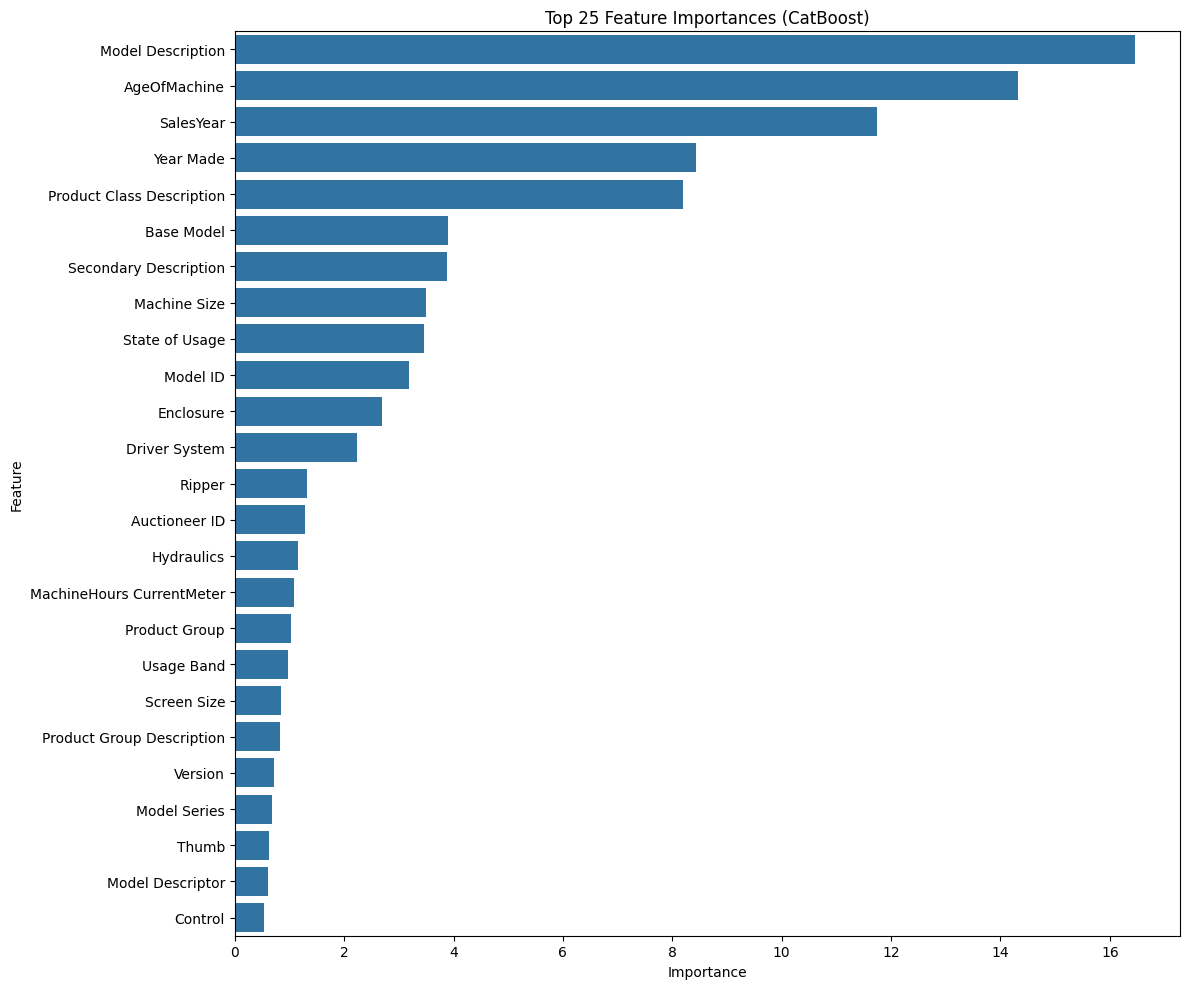

In [6]:

# Get feature importances
importances = model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(25) # Plot the top 25 features
)
plt.title('Top 25 Feature Importances (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

plt.savefig('catboost_feature_importance.png')
print("Successfully saved 'catboost_feature_importance.png'")